# Bike sharing LSTM
https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset

Predict next count based on 50 last counts + weather data

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [7]:
dataset = pd.read_csv("london_bs.csv")
dataset['month'] = pd.to_datetime(dataset['timestamp']).dt.month

In [8]:
col = ['month','t1','t2','hum','wind_speed','weather_code','cnt']
dataset[col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   month         17414 non-null  int64  
 1   t1            17414 non-null  float64
 2   t2            17414 non-null  float64
 3   hum           17414 non-null  float64
 4   wind_speed    17414 non-null  float64
 5   weather_code  17414 non-null  float64
 6   cnt           17414 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 952.5 KB


In [99]:
train_df = dataset[col][:10000]
validation_df = dataset[col][10000:13000]
test_df = dataset[col][13000:]

In [143]:
scaler = MinMaxScaler(feature_range=(0,1)).fit(train_df)

In [144]:
def process_data(df, scaler, lookback):
    
    scaled_input = scaler.transform(df)
    
    X = [] 
    y = []

    # Target must be in the last column -1
    for i in range(len(scaled_input) - lookback - 1):
        X.append([scaled_input[(i+j)] for j in range(0,lookback)])
        y.append(scaled_input[i + lookback, -1]) # will predict t+1 = f([t-lookback -> t])
        
    return np.array(X), np.array(y)

In [145]:
lookback = 50

X_train, y_train = process_data(train_df, scaler=scaler, lookback=lookback)
X_valid, y_valid = process_data(validation_df, scaler=scaler, lookback=lookback)
X_test, y_test = process_data(test_df, scaler=scaler, lookback=lookback)

In [146]:
model = Sequential()
model.add(layers.LSTM(16, dropout=0.2, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(layers.LSTM(32, dropout=0.2, return_sequences=False))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 50, 16)            1536      
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                6272      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 7,841
Trainable params: 7,841
Non-trainable params: 0
_________________________________________________________________


In [159]:
callbacks = [
    #EarlyStopping(monitor='val_loss', patience=4),
    ModelCheckpoint(filepath='model.h5')
]

history = model.fit(
    x = X_train, 
    y = y_train,
    epochs=30,
    batch_size=128, 
    validation_data=(X_valid,y_valid),
    callbacks = callbacks,
    verbose=1
)

Train on 9949 samples, validate on 2949 samples
Epoch 1/30
9949/9949 [==============================] - 13s 1ms/step - loss: 0.0452 - val_loss: 0.0379
Epoch 2/30
9949/9949 [==============================] - 12s 1ms/step - loss: 0.0442 - val_loss: 0.0444
Epoch 3/30
9949/9949 [==============================] - 13s 1ms/step - loss: 0.0424 - val_loss: 0.0408
Epoch 4/30
9949/9949 [==============================] - 14s 1ms/step - loss: 0.0412 - val_loss: 0.0425
Epoch 5/30
9949/9949 [==============================] - 14s 1ms/step - loss: 0.0395 - val_loss: 0.0320
Epoch 6/30
9949/9949 [==============================] - 14s 1ms/step - loss: 0.0380 - val_loss: 0.0301
Epoch 7/30
9949/9949 [==============================] - 14s 1ms/step - loss: 0.0378 - val_loss: 0.0381
Epoch 8/30
9949/9949 [==============================] - 14s 1ms/step - loss: 0.0375 - val_loss: 0.0368
Epoch 9/30
9949/9949 [==============================] - 14s 1ms/step - loss: 0.0367 - val_loss: 0.0333
Epoch 10/30
9949/9949 [==

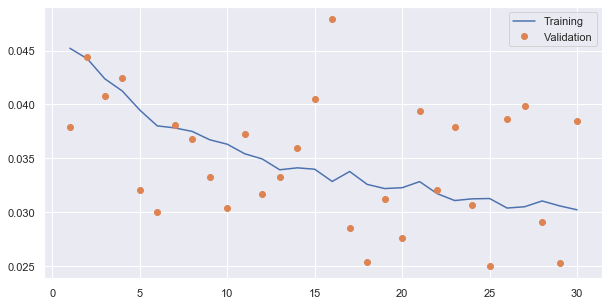

In [160]:
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs = range(1, len(loss)+1)

fig,ax=plt.subplots(figsize=(10,5))
plt.plot(epochs, loss, '-', label='Training')
plt.plot(epochs, val_loss, 'o', label='Validation')
plt.legend()

In [161]:
y_pred = model.predict(X_test)

(0, 200)

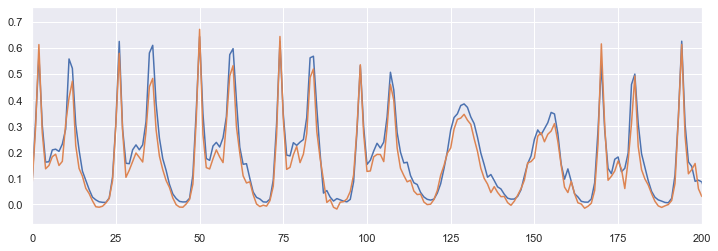

In [166]:
fig,ax=plt.subplots(figsize=(12,4))
plt.plot(y_test)
plt.plot(y_pred)
plt.xlim(0,200)